# Leveraging Python for Spatial Data Science

## [Spatial Data Science Bootcamp Paris](https://spatial-data-science-conference.com/bootcamps/2023/) October 26th, 2023

[Florian Bayer](https://www.linkedin.com/in/florian-bayer-a4117b30/), PhD in Public Health, MSc in Geography

Health geographer at Agence de la biomédecine, University lecturer at Paris Panthéon Sorbonne and ENSG

# Objective
The objective of this workshop is to provide an overview of spatial analysis tools that enable leveraging spatial dimension in your analyses.

The data comes from the [french health ministry.](https://annuaire.sante.fr/web/site-pro/extractions-publiques)

We will focus on the issue of the spatial distribution of self-employed general practitioners (not employed by a healthcare institution) in Paris and its outskirts. 

The goal is to determine whether there are spatial disparities in the distribution of general practitioners related to the population.

# Workshop Outline:

- Data management and geocoding
- Introduction to the Modifiable Areal Unit Problem (MAUP)
- Frontier effect
- Hot Spot Detection and spatial autocorrelation


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import os
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Import general practitioners (GPs) data 
Data have been preprocessed, see *BC_0_data_processing.ipynb* for more details. 

In [3]:
data_dir = "data"
file="data_bootcamp.pckl"
pckl_path = f"{data_dir}{os.path.sep}{file}"

gp_data = pd.read_pickle(pckl_path)
gp_data.head() 

,GPid,lastname,firstname,name,citycode,state,q
0,810000231778,SENBEL,CLAUDE,CDS MEDIKSANTE,75117,75,206 Boulevard PEREIRE 75017 PARIS Paris
1,810000459833,DAVEAU,PASCALE,CABINET DU DR PASCALE DAVEAU,75056,75,11 RUE DE REIMS 75013 PARIS Paris
2,810000556125,PENDOLA-LUCHEL,ISABELLE,CABINET DU DR ISABELLE PENDOLA-LUCHEL,75056,75,37 RUE CHARCOT 75013 PARIS Paris
3,810000571660,CHIAVERINI,PHILIPPE,CABINET DU DR PHILIPPE CHIAVERINI,75056,75,52 RUE MADEMOISELLE 75015 PARIS Paris
4,810000582683,GUEDJ,CHANTAL,CABINET DU DR CHANTAL GUEDJ,92051,92,113 AVENUE CHARLES DE GAULLE 92200 NEUILLY SUR...


# Geocoding GPs
For geocoding, we use the free [addok service](https://github.com/addok/addok), which is well-suited for French data. It is also possible to use [OSM's Nominatim](https://nominatim.org/release-docs/latest/).

To speed up geocoding, we utilize the [CSV plugin](https://github.com/addok/addok-csv) of addok. An intermediate CSV file is required. However, it is also possible to use the [/search/ endpoint](https://addok.readthedocs.io/en/latest/api/#search) for more options (result types, filters, etc.).

Only the 'q' column is used for geocoding.

In [4]:
source_path = os.path.join(data_dir, 'GP_adress.csv')
gp_data.q.to_csv(source_path, index=False)

## ADDOK
We use the example from [addok doc](https://addok.readthedocs.io/en/latest/examples/#geocoding-a-whole-file) to geocode *'GP_adress.csv'*

In [5]:
%%time

import requests

addok_url = 'http://api-adresse.data.gouv.fr/search/csv/'

def geocode(filepath_in):
    output_dir = os.path.dirname(filepath_in)  
    with open(filepath_in, 'rb') as f:
        filename, response = post_to_addok(filepath_in, f.read())
        output_path = os.path.join(output_dir, filename)  
        write_response_to_disk(output_path, response)

def write_response_to_disk(filename, response, chunk_size=1024):
    with open(filename, 'wb') as fd:
        for chunk in response.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

def post_to_addok(filename, filelike_object):
    files = {'data': (filename, filelike_object)}
    response = requests.post(addok_url, files=files)
    content_disposition = response.headers['content-disposition']
    filename = content_disposition[len('attachment; filename="'):-len('"')]
    return filename, response

geocode(source_path)


CPU times: user 55.1 ms, sys: 4.13 ms, total: 59.3 ms
Wall time: 17.8 s


## Checking the results

In [6]:
geocode_path = os.path.join(data_dir, 'geocoded.csv')

geocoded = pd.read_csv(geocode_path,dtype={"result_citycode":object, 'result_oldcitycode':object})
geocoded["result_score"] = round(geocoded["result_score"],2)
geocoded.head()

,q,latitude,longitude,result_label,result_score,result_score_next,result_type,result_id,result_housenumber,result_name,result_street,result_postcode,result_city,result_context,result_citycode,result_oldcitycode,result_oldcity,result_district,result_status
0,206 Boulevard PEREIRE 75017 PARIS Paris,48.880461,2.288405,206 Boulevard Pereire 75017 Paris,0.84,NaN,housenumber,75117_7258_00206,206,206 Boulevard Pereire,Boulevard Pereire,75017,Paris,"75, Paris, Île-de-France",75117,NaN,NaN,Paris 17e Arrondissement,ok
1,11 RUE DE REIMS 75013 PARIS Paris,48.828374,2.371458,11 Rue de Reims 75013 Paris,0.80,NaN,housenumber,75113_8109_00011,11,11 Rue de Reims,Rue de Reims,75013,Paris,"75, Paris, Île-de-France",75113,NaN,NaN,Paris 13e Arrondissement,ok
2,37 RUE CHARCOT 75013 PARIS Paris,48.829844,2.369682,37 Rue Charcot 75013 Paris,0.80,NaN,housenumber,75113_1786_00037,37,37 Rue Charcot,Rue Charcot,75013,Paris,"75, Paris, Île-de-France",75113,NaN,NaN,Paris 13e Arrondissement,ok
3,52 RUE MADEMOISELLE 75015 PARIS Paris,48.843300,2.299716,52 Rue Mademoiselle 75015 Paris,0.83,NaN,housenumber,75115_5893_00052,52,52 Rue Mademoiselle,Rue Mademoiselle,75015,Paris,"75, Paris, Île-de-France",75115,NaN,NaN,Paris 15e Arrondissement,ok
4,113 AVENUE CHARLES DE GAULLE 92200 NEUILLY SUR...,48.881485,2.269683,113 Avenue Charles de Gaulle 92200 Neuilly-sur...,0.77,NaN,housenumber,92051_1436_00113,113,113 Avenue Charles de Gaulle,Avenue Charles de Gaulle,92200,Neuilly-sur-Seine,"92, Hauts-de-Seine, Île-de-France",92051,NaN,NaN,NaN,ok


Let's check the results

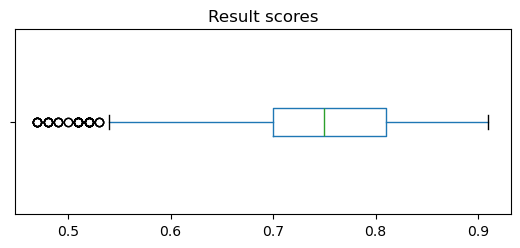

In [7]:
fig_box, ax_box = plt.subplots()
boxplot= geocoded.boxplot(column=['result_score'], vert=False, grid=False, ax=ax_box)
ax_box.set_xlabel('') 
ax_box.set_yticklabels([])
ax_box.set_title('Result scores')

fig_box.set_size_inches(fig_box.get_size_inches()[0], fig_box.get_size_inches()[1] / 2)
plt.show()


Some matches have scores lower than 0.5, let's investigate : 

In [8]:
geocoded[['q','result_label','result_score']].sort_values("result_score", ascending=True).query("result_score<0.5")

,q,result_label,result_score
603,2 Boulevard DE L'EUROPE 91022 EVRY CEDEX Essonne,2 Boulevard de l'Europe - Valéry Giscard d'Est...,0.47
9806,2 Boulevard DE L'EUROPE 91022 EVRY CEDEX Essonne,2 Boulevard de l'Europe - Valéry Giscard d'Est...,0.47
2224,2 Boulevard DE L'EUROPE 91022 EVRY CEDEX Essonne,2 Boulevard de l'Europe - Valéry Giscard d'Est...,0.47
1242,48 Avenue DU PRESIDENT ROOSEVELT 94320 THIAIS ...,48 Av du Pdt Franklin Roosevelt 94320 Thiais,0.47
4890,48 Avenue DU PRESIDENT ROOSEVELT 94320 THIAIS ...,48 Av du Pdt Franklin Roosevelt 94320 Thiais,0.47
2722,2 Boulevard DE L'EUROPE 91022 EVRY CEDEX Essonne,2 Boulevard de l'Europe - Valéry Giscard d'Est...,0.47
7092,2 Boulevard DE L'EUROPE 91022 EVRY CEDEX Essonne,2 Boulevard de l'Europe - Valéry Giscard d'Est...,0.47
5255,Allee D'ESTIENNE D ORVES 93701 DRANCY CEDEX Se...,Rue d’Estienne d’Orves 93700 Drancy,0.48
212,Allee D'ESTIENNE D ORVES 93701 DRANCY CEDEX Se...,Rue d’Estienne d’Orves 93700 Drancy,0.48
330,Allee D'ESTIENNE D ORVES 93701 DRANCY CEDEX Se...,Rue d’Estienne d’Orves 93700 Drancy,0.48


The vast majority of the results are localized at the `house number` : 

In [9]:
geocoded.groupby('result_type').agg({'result_type':'count'})

,result_type
result_type,
housenumber,10400
locality,6
street,469


Now, let's check that the points are in the correct municipalities. To do this, we compare the `citycodes` from the input source to the `geocoded citycodes`.

In [10]:
gp_data_xy = pd.concat([gp_data,geocoded[['latitude','longitude','result_label','result_score','result_type', 'result_citycode','result_oldcitycode']]], axis = 1)
gp_data_xy.query("citycode!=result_citycode")

,GPid,lastname,firstname,name,citycode,state,q,latitude,longitude,result_label,result_score,result_type,result_citycode,result_oldcitycode
1,810000459833,DAVEAU,PASCALE,CABINET DU DR PASCALE DAVEAU,75056,75,11 RUE DE REIMS 75013 PARIS Paris,48.828374,2.371458,11 Rue de Reims 75013 Paris,0.80,housenumber,75113,NaN
2,810000556125,PENDOLA-LUCHEL,ISABELLE,CABINET DU DR ISABELLE PENDOLA-LUCHEL,75056,75,37 RUE CHARCOT 75013 PARIS Paris,48.829844,2.369682,37 Rue Charcot 75013 Paris,0.80,housenumber,75113,NaN
3,810000571660,CHIAVERINI,PHILIPPE,CABINET DU DR PHILIPPE CHIAVERINI,75056,75,52 RUE MADEMOISELLE 75015 PARIS Paris,48.843300,2.299716,52 Rue Mademoiselle 75015 Paris,0.83,housenumber,75115,NaN
20,810100025484,YOKA,HUGUETTE,CABINET DU DR HUGUETTE YOKA,75056,75,36 AVENUE NIEL 75017 PARIS Paris,48.881717,2.296001,36 Avenue Niel 75017 Paris,0.80,housenumber,75117,NaN
26,810101079472,SOOBRON,Sarvesh,CABINET DU DR SARVESH SOOBRON,75056,75,42 RUE CURIAL 75019 PARIS Paris,48.892155,2.372772,42 Rue Curial 75019 Paris,0.80,housenumber,75119,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10860,810100216117,SAUVAGE-RIGAL,SOPHIE,CABINET DU DR SOPHIE SAUVAGE-RIGAL,75056,75,1 RUE OLIVIER DE SERRES 75015 PARIS Paris,48.837089,2.298739,1 Rue Olivier de Serres 75015 Paris,0.85,housenumber,75115,NaN
10861,810100373447,FIORINA,EMILY,CABINET DU DR EMILY FIORINA,75056,75,47 RUE FESSART 75019 PARIS Paris,48.876723,2.383698,47 Rue Fessart 75019 Paris,0.80,housenumber,75119,NaN
10862,810100387579,DUPUI,Julien,CABINET DU DR Julien DUPUI,75056,75,38 BOULEVARD SAINT MARCEL 75005 PARIS Paris,48.838847,2.357659,38 Boulevard Saint-Marcel 75005 Paris,0.84,housenumber,75105,NaN
10863,810100413664,DODILLE,LAURENCE,CABINET DU DR ALAIN AMSLEM,75056,75,94 RUE BRILLAT SAVARIN 75013 PARIS Paris,48.824532,2.343058,94 Rue Brillat-Savarin 75013 Paris,0.84,housenumber,75113,NaN


It appears there is an issue with the department of Paris. 

It's actually about the city code of Paris (75056) versus the codes of the 20 districts (arrondissements) of Paris (751xx).

We can at least manually check the lowest scores to ensure they are geocoded correctly. 

In [11]:
gp_data_xy[['q','result_label','result_score','state']].query("state=='75' and result_score<0.65").drop_duplicates()

,q,result_label,result_score,state
54,178 Rue DE VAUGIRARD 75738 PARIS CEDEX 15 Paris,178 Rue de Vaugirard 75015 Paris,0.63,75
321,12 Rue ARMAND MOISANT 75731 PARIS CEDEX 15 Paris,12 Rue Armand Moisant 75015 Paris,0.62,75
410,37 Rue DES VOLONTAIRES 75730 PARIS CEDEX 15 Paris,37 Rue des Volontaires 75015 Paris,0.63,75
525,18 Place LACHAMBEAUDIE 75570 PARIS CEDEX 12 Paris,18 Place Lachambeaudie 75012 Paris,0.63,75
542,44 Rue D AMSTERDAM 75311 PARIS CEDEX 09 Paris,44 Rue d'Amsterdam 75009 Paris,0.60,75
796,3 Rue DU MAROC 75954 PARIS CEDEX 19 Paris,3 Rue du Maroc 75019 Paris,0.56,75
997,2 Rue AMBROISE PARE 75462 PARIS CEDEX 10 Paris,2 Rue Ambroise Paré 75010 Paris,0.60,75
1166,20 BIS RUE DARU 75008 PARIS Paris,20b Rue Daru 75008 Paris,0.62,75
2729,29 BIS RUE MONGE 75005 PARIS Paris,29b Rue Monge 75005 Paris,0.64,75
3878,34 BIS RUE VIGNON 75009 PARIS Paris,34b Rue Vignon 75009 Paris,0.64,75


Now let's check that the GPs coordinates outside of Paris are in the correct municipality.

In [12]:
gp_data_xy[~((gp_data_xy['citycode'] == gp_data_xy['result_citycode']) | (gp_data_xy['citycode'] == gp_data_xy['result_oldcitycode'])) & (gp_data_xy['state'] != '75')]

,GPid,lastname,firstname,name,citycode,state,q,latitude,longitude,result_label,result_score,result_type,result_citycode,result_oldcitycode


The geocoding seems excellent, which is very uncommon. The source file has likely undergone a data management step, and the reference data for the source and addok addresses seem close.

# Dataframe to Geodataframe
Now we can create a geodataframe for our analyses.

In [13]:
import geopandas as gpd 

geo_gp = gpd.GeoDataFrame(
    gp_data_xy[['GPid','lastname','firstname','name','result_label','result_citycode','state','latitude','longitude']],
    geometry=gpd.points_from_xy(gp_data_xy.longitude, gp_data_xy.latitude),
    crs="EPSG:4326"
)

geo_gp = geo_gp.to_crs(2154)
geo_gp['latitude'] = geo_gp.geometry.centroid.x
geo_gp['longitude'] = geo_gp.geometry.centroid.y

Data exploration with Geopandas

In [14]:
geo_gp.geometry.explore(tiles='CartoDB Positron')

# Reading and loading Paris' districts
GeoJSON format, EPSG 4326

In [15]:
url_cities = "https://raw.githack.com/fbxyz/Bootcamp/main/com_idf.geojson"
bbox_4326 = [2.08, 48.64, 2.7, 49.04]

b = (bbox_4326[0], bbox_4326[1], bbox_4326[2], bbox_4326[3])

gdf_cities = gpd.read_file(url_cities,
                           bbox=(b))

gdf_cities = gdf_cities.set_crs(4326)
gdf_cities = gdf_cities.to_crs(2154)
bbox_2154 = gdf_cities.total_bounds

gdf_cities.head()

ERROR 1: PROJ: proj_create_from_database: Open of /home/florian/anaconda3/envs/geo/envs/bootcamp_level/share/proj failed


HTTPError: HTTP Error 404: Not Found

In [ ]:
gdf_cities.explore(tiles='CartoDB Positron')

For this first part, we only keep the municipalities in the departments bordering the city of Paris.

In [ ]:
gdf_parispc = gdf_cities.query("insee_dep in ('75','92','93','94')").copy()

gdf_parispc["latitude"] = gdf_parispc.centroid.y
gdf_parispc["longitude"] = gdf_parispc.centroid.x
    
gdf_parispc.explore(tiles='CartoDB Positron')

Now, let's create a layer for the departments.

In [ ]:
gdf_dep = gdf_cities[['insee_dep','geometry']].dissolve(by='insee_dep')
bbox_parispc = gdf_parispc.buffer(1000).total_bounds
gdf_dep = gdf_dep.clip(bbox_parispc)
bbox_parispc

## Mapping the GPs

Let's count and map the number of GPs per municipality.

In [ ]:
city_gp = geo_gp.groupby(['result_citycode']).agg({'GPid':'count'}).reset_index()
city_gp.columns = ['insee_com','GPcount']

In [ ]:
city_map = gdf_parispc.merge(city_gp,on='insee_com',how='left')

We will use matplotlib to map the results.

The basemap includes Paris and the municipalities in its immediate suburbs.

In [ ]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

def main_map(bbox):
    """
    Create a main map using Matplotlib.

    Parameters:
        bbox (list): A list containing the bounding box coordinates [left, bottom, right, top].

    Returns:
        fig (matplotlib.figure.Figure): The Matplotlib figure.
        ax_main (matplotlib.axes.Axes): The main axis for the map.
    """
    
    cm = 1 / 2.54
    fig, ax_main = plt.subplots(sharex='all', sharey='all', figsize=(18 * cm, 18 * cm))
    ax_main.axes.get_xaxis().set_visible(False) 
    ax_main.axes.get_yaxis().set_visible(False)  
    ax_main.set_xlim(left=bbox[0], right=bbox[2])
    ax_main.set_ylim(bottom=bbox[1], top=bbox[3])
    city_map.plot(ax=ax_main, color="#f4f4f4", edgecolor="#777777", linewidth=0.25, zorder=0)
    
    # Let's improve the visualization by adding the outlines of the departments.
    gdf_dep.boundary.plot(ax=ax_main, color="#4d4d4d", linewidth=0.35, linestyle='-', facecolor="none", zorder=5)
    
    scalebar = AnchoredSizeBar(ax_main.transData,
                           2000, '2 km',
                           loc='lower right',
                           pad=1,
                           color="#777777",
                           label_top=True,
                           frameon=False,
                           prop={'size': 6},
                           zorder=1)
    ax_main.add_artist(scalebar)


    return fig, ax_main

In [ ]:
fig_gp, ax_gp = main_map(bbox_parispc)

In [ ]:
def plot_scattermap(ax, data, size_column, title, legend_title, color='steelblue', scale=1, legend=True):
    """
    Create a scatter plot and a custom legend on the given axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axis where the scatter plot and legend will be created.
        data (pandas.DataFrame): The data containing coordinates and size information.
        size_column (str): The name of the column in 'data' that contains the point sizes.
        title (str): The title for the scatter plot.
        legend_title (str): The title for the legend.
        color (str): The fill color of the scatter plot.
        scale (float): Scaling factor for point sizes in the scatter plot.

    Returns:
        scatter (matplotlib.collections.PathCollection): The scatter plot.
        legend_points (list of matplotlib.collections.PathCollection): List of points in the legend.
    """
    min_size = data[size_column].min()
    median_size = data[size_column].median()
    max_size = data[size_column].max()
    
    data.sort_values(size_column, inplace=True, ascending=False)
    
    scatter = ax.scatter(data['longitude'], data['latitude'], c=color,
                          edgecolor='w', linewidths=0.2,
                          s=data[size_column]*scale, label='Scatter Points', zorder=3)
    
    ax.set_title(title)

    
    if legend : 
    
        leg_val = [max_size, median_size, min_size]

        legend_points = [
            ax.scatter([], [], c=color, edgecolor='w', linewidths=0.2, s=size*scale, label=f'{int(size)}', zorder=2) for size in leg_val
        ]

        legend_ax = ax.legend(handles=legend_points, title=legend_title, loc='lower left', frameon=False)
        title_text = legend_ax.get_title()
        title_text.set_position((0, 15)) 
    
    return scatter


In [ ]:
plot_scattermap(ax_gp, city_map, 'GPcount', "General practitioners in Paris area (aug. 2023)", "Number of GPs", scale=1)
fig_gp

But this map isn't very informative because the distribution of GPs is relatively similar to that of the population

In [ ]:
fig_pop, ax_pop = main_map(bbox_parispc)

plot_scattermap(ax_pop, city_map, 'population', "Population in Paris area, 2022", "Population", color="#00afb9", scale=0.002)
fig_pop;

# MAUP
## Issue
The MAUP (Modifiable Areal Unit Problem) is an issue that illustrates how administrative boundary can create the illusion of patterns when, in fact, it's an artifact.

To illustrate this, we will create a 10km grid and a fictional administrative mesh.

In [ ]:
from shapely.geometry import box, Point, MultiPoint
from shapely.ops import orient, voronoi_diagram
import random


def create_grid(epsg_code, bounding_box, resolution, return_centroids=False):
    """
    Create a grid of squares within a specified bounding box with a given resolution.

    Parameters:
        epsg_code (int): The EPSG code specifying the coordinate reference system (CRS) of the grid.
        bounding_box (list): A list containing the coordinates of the bounding box in the form [xmin, ymin, xmax, ymax].
        resolution (float): The resolution of each square in units of the specified CRS.
        return_centroids (bool): If True, return only the centroids of the squares.

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame containing the grid of squares or centroids.
    
    Example:
        epsg = 2154
        bounding_box = [632217, 6882276, 678065, 6838152]
        resolution = 10000  # Resolution of each square in CRS units
        grid = create_grid(epsg, bounding_box, resolution)
    """
    crs = f"EPSG:{epsg_code}"
    
    xmin, ymin, xmax, ymax = bounding_box
    
    x_coords = list(range(int(xmin), int(xmax), int(resolution)))
    y_coords = list(range(int(ymin), int(ymax), int(resolution)))
    
    features = []
    for x in x_coords:
        for y in y_coords:
            square = box(x, y, x + resolution, y + resolution)
            if return_centroids:
                centroid = square.centroid
                features.append(centroid)
            else:
                features.append(square)
    
    grid_gdf = gpd.GeoDataFrame({'geometry': features}, crs=crs)
    grid_gdf.geometry = grid_gdf.geometry.apply(orient, args=(-1,)) # to avoid errors with Altair
    
    if return_centroids:
        grid_gdf["latitude"] = grid_gdf.geometry.y
        grid_gdf["longitude"] = grid_gdf.geometry.x
    else :
        grid_gdf["latitude"] = grid_gdf.centroid.y
        grid_gdf["longitude"] = grid_gdf.centroid.x
        
    grid_gdf['OBJECTID'] = grid_gdf.index
    
    return grid_gdf

We will create a 10 km by 10 km grid (16 squares) and evenly distributed points within this grid

In [ ]:
epsg=2154

bbox_city = city_map.total_bounds
grid_10km = create_grid(epsg, bbox_city, 10000)

bbox_grid = grid_10km.total_bounds
point_1km = create_grid(epsg, bbox_grid, 2000, True)

and a fictional administrative mesh based on 16 voronoi diagram

In [ ]:
def generate_random_points_voronoi(bbox, num_points, output_epsg):
    """
    Generate a GeoDataFrame representing Voronoi polygons for random points within a specified bounding box.

    Parameters:
        bbox (tuple): A tuple containing the bounding box coordinates (bbox_min_x, bbox_min_y, bbox_max_x, bbox_max_y).
        num_points (int): The number of random points to generate.
        output_epsg (int): The EPSG code for the output coordinate reference system (CRS).

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame containing Voronoi polygons within the specified bounding box.
    """
    random.seed(2)
    
    bbox_min_x, bbox_min_y, bbox_max_x, bbox_max_y = bbox
    random_points = []
    
    for _ in range(num_points):
        x = random.uniform(bbox_min_x, bbox_max_x)
        y = random.uniform(bbox_min_y, bbox_max_y)
        random_points.append(Point(x, y))
    
    points = MultiPoint(random_points)
    regions = voronoi_diagram(points)
    
    # Create a GeoDataFrame from the Voronoi regions
    gdf = gpd.GeoDataFrame(geometry=[regions], crs=f'EPSG:{output_epsg}')
    
    # Use intersection to clip the GeoDataFrame with the bounding box
    gdf = gdf.clip(bbox)
    gdf = gdf.explode(index_parts=False).reset_index(drop=True)
    gdf['OBJECTID'] = gdf.index
    
    gdf["latitude"] = gdf.centroid.y
    gdf["longitude"] = gdf.centroid.x
    
    return gdf

In [ ]:
voronoi_gdf = generate_random_points_voronoi(bbox_grid, 16, epsg)

Let's illustrate the result using Altair.

In [ ]:
def configure_axis(ax):

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

def main_maup(cm = 1 / 2.54):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(25 * cm, 25 * cm))

    configure_axis(ax1)
    configure_axis(ax2)

    grid_10km.plot(ax=ax1, color="#f4f4f4", edgecolor="#777777", linewidth=2, zorder=0)
    ax1.set_title("10 km by 10 km grid")

    voronoi_gdf.plot(ax=ax2, color="#f4f4f4", edgecolor="#777777", linewidth=2, zorder=0)
    ax2.set_title("Fictional administrative mesh")

    return fig, ax1, ax2

fig_maup, ax_regu, ax_voro = main_maup()
    
point_1km.plot(ax=ax_regu, color="steelblue", zorder=1, markersize=2)
point_1km.plot(ax=ax_voro, color="steelblue", zorder=1, markersize=2)


Now, let's aggregate the points within each administrative mesh.

In [ ]:
grid_10km['count'] = grid_10km.sjoin(point_1km).groupby('OBJECTID_left').size()
voronoi_gdf['count'] = voronoi_gdf.sjoin(point_1km).groupby('OBJECTID_left').size()


In [ ]:
fig_maup_s, ax_regu_s, ax_voro_s = main_maup()

plot_scattermap(ax_regu_s, grid_10km, 'count', "Population in Paris area, 2022", "Population", color="#00afb9", scale=15, legend=False)
plot_scattermap(ax_voro_s, voronoi_gdf, 'count', "Population in Paris area, 2022", "Population", color="#00afb9", scale=15, legend=False)
fig_maup_s;

This example gives the impression that the observed phenomenon is more significant in the northwest and weaker in the southeast.

While in reality, it is evenly distributed across the entire study area.

And it's even worse if you don't adhere to the rules of graphic semiotics (your eye cannot perceive proportionality with different shades of gray; only size can convey this information).

In [ ]:
def customize_legend(_legend):
    _legend.set_frame_on(False)

    for line in _legend.get_lines():
        line.set_markeredgecolor("#777777")
        line.set_markeredgewidth(0.5)

fig_maup_c, ax_regu_c, ax_voro_c = main_maup()

legend = {'loc':'lower left', 
          'bbox_to_anchor':(0, -.35), 
          'markerscale':1, 
          'title_fontsize':'medium', 
          'fontsize':'small',
          'title' : 'Population'}

grid_10km.plot(ax=ax_regu_c, column='count', cmap='OrRd', scheme='quantiles', edgecolor="#777777", 
               legend=True, 
               legend_kwds=legend )
customize_legend(ax_regu_c.get_legend())

voronoi_gdf.plot(ax=ax_voro_c, column='count', cmap='OrRd', scheme='FisherJenks', edgecolor="#777777",
                 legend=True, 
                 legend_kwds=legend )
customize_legend(ax_voro_c.get_legend())

fig_maup_c;

## Solutions
An alternative is to normalize the result by using a denominator such as density or population.

In [ ]:
grid_10km['area'] = grid_10km.geometry.area /1000000
voronoi_gdf['area'] = voronoi_gdf.geometry.area /1000000

grid_10km['density'] = grid_10km['count'] / grid_10km['area'] 
voronoi_gdf['density'] = voronoi_gdf['count'] / voronoi_gdf['area'] 

In [ ]:
fig_maup_d, ax_regu_d, ax_voro_d = main_maup()

legend['title']="Density (km²)"

grid_10km.plot(ax=ax_regu_d, column='density', cmap='OrRd', scheme='quantiles', edgecolor="#777777", 
               legend=True, 
               legend_kwds=legend )
customize_legend(ax_regu_d.get_legend())

voronoi_gdf.plot(ax=ax_voro_d, column='density', cmap='OrRd', scheme='FisherJenks', k=4, edgecolor="#777777",
                 legend=True, 
                 legend_kwds=legend )
customize_legend(ax_voro_d.get_legend())

fig_maup_d;

And here is the result once applied to our study area

In [ ]:
city_map['area'] = city_map.geometry.area /1000000

fig_gp_n, ax_gp_n = main_map(bbox_parispc)

legend = {'loc':'lower left', 
          'markerscale':1, 
          'title_fontsize':'medium', 
          'fontsize':'small'}

city_map.plot(ax=ax_gp_n, column='GPcount', cmap='OrRd', scheme='FisherJenks', k=4,
              edgecolor="#777777",  linewidth=0.2,
              legend=True, legend_kwds=legend )
customize_legend(ax_gp_n.get_legend())

ax_gp_n.set_title("Number of GPs (avoid this representation)")
fig_gp_n;

In [ ]:
city_map['area'] = city_map.geometry.area /1000000
city_map["GP_density"] = city_map["GPcount"] / city_map['area']


fig_gp_d, ax_gp_d = main_map(bbox_parispc)

city_map.plot(ax=ax_gp_d, column='GP_density', cmap='OrRd', scheme='FisherJenks', k=4,
              edgecolor="#777777",  linewidth=0.2,
              legend=True, legend_kwds=legend )
customize_legend(ax_gp_d.get_legend())

ax_gp_d.set_title("Density of GPs (km2)")
fig_gp_d;

In [ ]:
city_map["GP_pop"] = city_map["GPcount"] / city_map['population'] * 100000

fig_gp_p, ax_gp_p = main_map(bbox_parispc)

city_map.plot(ax=ax_gp_p, column='GP_pop', cmap='OrRd', scheme='FisherJenks', k=4,
              edgecolor="#777777",  linewidth=0.2,
              legend=True, legend_kwds=legend )
customize_legend(ax_gp_p.get_legend())

ax_gp_p.set_title("GPs per million population")
fig_gp_p;

## Kernel Density Estimation (KDE)

Principe

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_bimodal_kernel_density_plot(data_mode1_params, data_mode2_params):
    """
    Generate a bimodal kernel density plot using Matplotlib and SciPy.

    Args:
        data_mode1_params (tuple): Parameters for the first normal distribution (mean, standard deviation, number of samples).
        data_mode2_params (tuple): Parameters for the second normal distribution (mean, standard deviation, number of samples).

    Returns:
        tuple: A tuple containing the Matplotlib figure and axis objects representing the bimodal kernel density plot.
    """
    np.random.seed(42)
    
    data_mode1 = np.random.normal(data_mode1_params[0], data_mode1_params[1], data_mode1_params[2])
    data_mode2 = np.random.normal(data_mode2_params[0], data_mode2_params[1], data_mode2_params[2])
    data = np.concatenate((data_mode1, data_mode2))

    kde = gaussian_kde(data)

    x_values = np.linspace(min(data), max(data), 1000)
    density_values = kde(x_values)

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.fill_between(x_values, density_values, alpha=0.5, label='Density', color='steelblue')

    ax.scatter(data, np.zeros_like(data), color='#D90429', s=20, label='Points at Y=0')

    ax.set_xlabel('X')
    ax.set_ylabel('Density')
    ax.set_title('Bimodal Kernel Density Plot')

    ax.legend()

    return fig, ax

data1 = (-2, 1, 25)
data2 = (2, 1, 100)
create_bimodal_kernel_density_plot(data1, data2)

plt.show()


## KDE with spatial data
It is then possible to bypass the territorial mesh to visualize the distribution of points (i.e., the GP's location).

But this time, the KDE function is used in both spatial dimensions.

In [ ]:
from scipy.stats import gaussian_kde

latitude = geo_gp['latitude']
longitude = geo_gp['longitude']

kde = gaussian_kde([latitude, longitude], bw_method=0.12)
x, y = np.meshgrid(np.linspace(latitude.min(), latitude.max(), 100), np.linspace(longitude.min(), longitude.max(), 100))
z = kde(np.vstack([x.ravel(), y.ravel()]))
z = z.reshape(x.shape)

fig_gp_kde, ax_gp_kde = main_map(bbox_parispc)

contour = ax_gp_kde.contourf(x, y, z, levels=6, cmap='Reds', alpha=0.6)

cbar = plt.colorbar(contour, ax=ax_gp_kde, shrink=0.7)

fig_gp_kde ;


# Frontier effect

Thanks to this tool, the administrative mesh is no longer a fictitious obstacle to the observed phenomena, provided that the data has a precision lower than the mesh.

However, we won't focus into KDE in this session. The results of the main KDE tools in Python are not in map units

For more information see : <cite>Silverman, B. W. (1986). Density estimation for statistics and data analysis (Vol. 26). CRC press.</cite>

## Regulard grid
Another option is to create a regular grid. For this, we will use h3pandas.

In [ ]:
import h3

def aggregate_h3_grid(gdf, aggregation_level, crs=2154):
    """
    Aggregate a GeoDataFrame using H3 hexagons and calculate density.

    Args:
        gdf (geopandas.GeoDataFrame): Input GeoDataFrame with geometries.
        aggregation_level (int): The H3 aggregation level to use.
        crs (int, optional): The EPSG code for the coordinate reference system (CRS).
                            Defaults to 2154.

    Returns:
        geopandas.GeoDataFrame: Aggregated GeoDataFrame with density calculated.

    """
    grid = gdf.to_crs(4326).copy()
    grid = grid[['geometry']]
    grid["n"] = 1
    grid = grid.h3.geo_to_h3_aggregate(aggregation_level, return_geometry=True)
    grid = grid.to_crs(crs)
    grid['dens'] = grid["n"] / grid.geometry.area
    if crs in (2154, 3857):
        grid['dens'] *= 1000000
    
    return grid



In [ ]:
fig_gp_h7, ax_gp_h7 = main_map(bbox_parispc)

grid_h7 = aggregate_h3_grid(geo_gp, 7)

grid_h7.plot(ax=ax_gp_h7, column='dens', cmap='OrRd', scheme='FisherJenks', k=4,
              edgecolor="#777777", linewidth=0.2, alpha=0.7, zorder=3,
              legend=True, legend_kwds=legend )

customize_legend(ax_gp_h7.get_legend())

ax_gp_h7.set_title("GPs density : H7")
fig_gp_h7;

In [ ]:
fig_gp_h8, ax_gp_h8 = main_map(bbox_parispc)

grid_h8 = aggregate_h3_grid(geo_gp, 8)

grid_h8.plot(ax=ax_gp_h8, column='dens', cmap='OrRd', scheme='FisherJenks', k=4,
              edgecolor="#777777", linewidth=0.2, alpha=0.7, zorder=3,
              legend=True, legend_kwds=legend )

customize_legend(ax_gp_h8.get_legend())

ax_gp_h8.set_title("GPs density : H8")
fig_gp_h8;

## MAUP and variance

Another effect of the MAUP is that as more data is aggregated at a larger mesh, the variance tends to zero.

The data produced with H3pandas clearly demonstrates this phenomenon for the density variance.

In [ ]:
var_dict = {}
for i in range(3, 9):
    d = aggregate_h3_grid(geo_gp, i).dens
    var_dict[f'h3_{i}'] = round(np.var(d))

keys = list(var_dict.keys())
values = list(var_dict.values())


In [ ]:
plt.plot(keys, values, marker='o', linestyle='-')

plt.xlabel('H3 aggregation level')
plt.ylabel('Variance')
plt.title('Smaller spatial units, increased variance')

plt.grid(True)
plt.show()

Finally, here are some good practices:

- Often, an administrative mesh is imposed by the study, but don't hesitate to critique it. In France, the maps with the new regions are a distortion for geographical analysis.
- Use the finest mesh whenever possible, even if you need to reaggregate the data later.
- There's nothing wrong with presenting results in various forms: administrative mesh, grid, kernel density. In some cases, the differences with the administrative mesh will be minimal, and only the latter may be retained for decision-makers.
- However, be cautious about statistical power: the finer the mesh, the fewer statistical units there will be, and the results can be affected."

# Hot Spot Detection / Spatial Autocorrelation

## Global Spatial Autocorrelation : Moran's $I$

### Create Spatial Weights Matrix

In [ ]:
from libpysal.weights.contiguity import Queen

w = Queen.from_dataframe(grid_h7,use_index=True)

fig_gp_queens, ax_gp_queens = main_map(bbox_parispc)

grid_h7.plot(ax=ax_gp_queens,color="#f4f4f4",
              edgecolor="#777777", linewidth=0.2,
              legend=False)


w.plot(grid_h7,
       ax=ax_gp_queens,
       edge_kws=dict(color='r', linestyle=':', linewidth=1, alpha=0.5),
       node_kws=dict(marker=''))

fig_gp_queens;

In [ ]:
from esda.moran import Moran
y = grid_h7['dens'].values
moran = Moran(y, w)
moran.I

#TODO : uniquement sur la zone d'étude


## Local Global Spatial Autocorrelation : $LISA$

# Travel Time

[more infos about IGN API](https://geoservices.ign.fr/documentation/services/api-et-services-ogc/itineraires/api)



In [ ]:
from geopy.distance import great_circle

def calculate_itinerary(start, end, max_distance=5, url="https://wxs.ign.fr/calcul/geoportail/itineraire/rest/1.0.0/route"):
    """
    Calculate a route using the IGN Geoportail itinerary service.

    Args:
        start (tuple): A tuple containing the latitude and longitude of the starting point.
        end (tuple): A tuple containing the latitude and longitude of the destination.
        max_distance (float, optional): The maximum allowed distance in kilometers between the starting and ending points.
            If the distance exceeds this value, itinerary calculation is skipped. Default is 5 kilometers.
        url (str, optional): The URL of the IGN Geoportail itinerary service. Default is the official URL.

    Returns:
        dict or None: A dictionary containing the calculated itinerary or None if an error occurs.

    Example:
        start_coords = (48.81876120037664, 2.3017215728759766)
        end_coords = (48.8287067867079, 2.324380874633789)
        itinerary = calculate_IGN_itinerary(start_coords, end_coords)
        if itinerary:
            print(itinerary)
    """
    
    # Calculate the distance between start and end
    distance = great_circle(start, end).kilometers
    
    if distance > max_distance:
        print(f"Distance between start and end is greater than {max_distance} km. Itinerary calculation skipped.")
        return None

    start_coords = f"{start[1]},{start[0]}"
    end_coords = f"{end[1]},{end[0]}"
    
    params = {
        "resource": "bdtopo-pgr",
        "profile": "car",
        "optimization": "shortest",
        "start": start_coords,
        "end": end_coords,
        "intermediates": "",
        "getSteps" : "false",
        "constraints": '{"constraintType":"banned","key":"wayType","operator":"=","value":"tunnel"}'
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        itinerary = response.json()
        return itinerary
    else:
        print(f"Error {response.status_code}: Unable to calculate the itinerary.")
        return None

start_coords = (48.81876120037664, 2.3017215728759766)  
end_coords = (48.8287067867079, 2.324380874633789)    

itinerary = calculate_itinerary(start_coords, end_coords)
if itinerary:
    print(itinerary)


# Conclusion

TODO